## Importing the Dependencies

In [62]:
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import xgboost as xgb
import math
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn import metrics

## Loading Datasets

In [41]:
df =  pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', nrows = 50000)

## Data Preprocessing

In [42]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [43]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


### Feature Engineering

In [45]:
#Function to get distance in kilomerters using pickup and dropoff longitudes and latitudes using haversine formula
def haversine(lat1, lon1, lat2, lon2):
    
  # convert decimal degrees to radians 
  lon1=np.deg2rad(lon1.to_numpy())
  lat1=np.deg2rad(lat1.to_numpy())
  lon2=np.deg2rad(lon2.to_numpy())
  lat2=np.deg2rad(lat2.to_numpy())

  # haversine formula 
  dlon = lon2 - lon1 
  dlat = lat2 - lat1 
  a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
  c = 2 * np.arcsin(np.sqrt(a)) 
  r = 6372.8 # Radius of earth in kilometers
  return np.around(c * r, decimals=2) 




In [46]:
#Adding New Features Using 'pickup_datetime' column
df['pickup_datetime'] = pd.to_datetime(df["pickup_datetime"])
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['date'] = df['pickup_datetime'].dt.day
df['day'] = df['pickup_datetime'].dt.dayofweek
df['hours'] = df['pickup_datetime'].dt.hour
df.drop('pickup_datetime',axis = 1,inplace = True)
df.drop('key',axis = 1,inplace = True)

# Adding peak_hours as [18,19,20]
df['peak_hours'] = df['hours'].apply(lambda x: 1 if x in [18,19,20] else 0)


#Adding 'distance_travelled' column extracted using haversine function
df['distance_travelled'] = haversine(df['pickup_latitude'],df['pickup_longitude'],\
                                            df['dropoff_latitude'],df['dropoff_longitude'])


In [47]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fare_amount         50000 non-null  float64
 1   pickup_longitude    50000 non-null  float64
 2   pickup_latitude     50000 non-null  float64
 3   dropoff_longitude   50000 non-null  float64
 4   dropoff_latitude    50000 non-null  float64
 5   passenger_count     50000 non-null  int64  
 6   year                50000 non-null  int64  
 7   month               50000 non-null  int64  
 8   date                50000 non-null  int64  
 9   day                 50000 non-null  int64  
 10  hours               50000 non-null  int64  
 11  peak_hours          50000 non-null  int64  
 12  distance_travelled  50000 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 5.0 MB


### Data Cleaning

In [48]:
'''Function to Clean Following types of Messy data
1 - Drop Nan Value
2 - Drop negative,zero and fare amount over 200$
3 - Drop No of Passengers <= 0 and >= 7
4 - Drop outliers in longitudes,latitudes and distance
5 - Drop Key
'''
def clean_data(df):
    new_df = df[
        ((df['fare_amount'] > 0) & (df['fare_amount'] <= 200)) &
        ((df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73)) & 
        ((df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)) &
        ((df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -73)) & 
        ((df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)) & 
        ((df['passenger_count'] > 0) & (df['passenger_count'] <= 6)) &
        ((df['distance_travelled'] > 0) & (df['distance_travelled'] <= 200))
        
    ]
    return new_df


In [49]:
print("Length Before Cleaning: ",len(df))
df = clean_data(df)
print("Length After Cleaning: ",len(df))

Length Before Cleaning:  50000
Length After Cleaning:  48154


### Exploratory Data Analysis

<AxesSubplot:title={'center':'Correlation Heatmap'}>

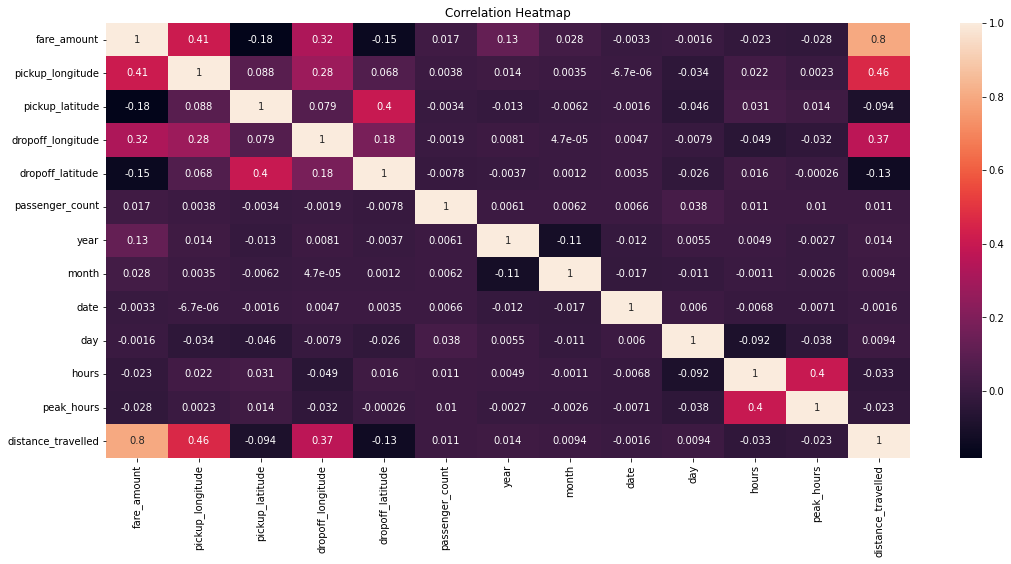

In [50]:
plt.figure(figsize = (18,8))
plt.title('Correlation Heatmap')
corr = df.corr()
corr
sns.heatmap(corr, annot = True)

Text(0.5, 1.0, 'Histogram of no of Passengers')

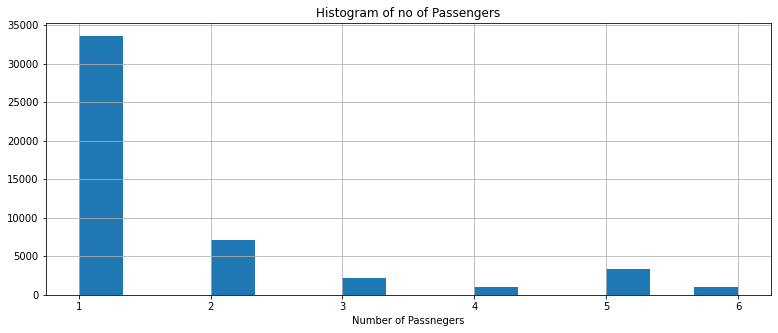

In [51]:
#Histogram of Passengers
df.passenger_count.hist(bins = 15,figsize=(13,5))
plt.xlabel('Number of Passnegers')
plt.title('Histogram of no of Passengers')

Text(0.5, 1.0, 'Histogram of Fare Amount')

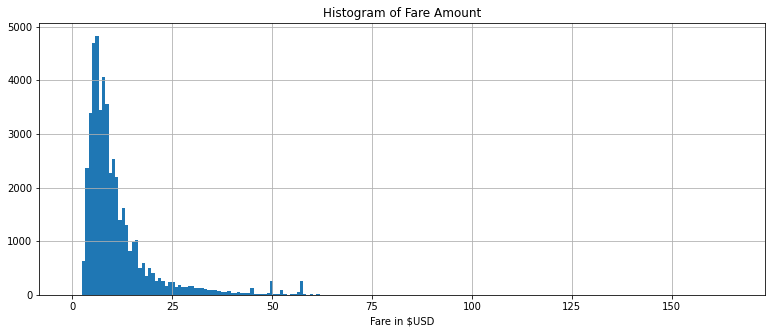

In [52]:
#Histogram of Fare Amount
df.fare_amount.hist(bins = 200,figsize = (13,5))
plt.xlabel('Fare in $USD')
plt.title('Histogram of Fare Amount')

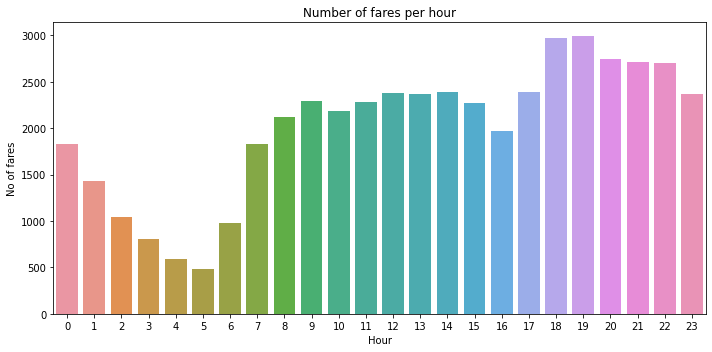

In [53]:
#Number 0f Fares Per Hour
plt.figure(figsize = (10,5))
new_df = df.groupby('hours', as_index = False)['fare_amount'].agg(['count']).sort_values(by = 'hours', ascending = True)
ax = sns.barplot(x=new_df.index, y=new_df['count'])
ax.set(xlabel='Hour', ylabel='No of fares')  
plt.title('Number of fares per hour')
plt.tight_layout()
plt.show()

### Machine Learning

In [54]:
#Splitting Data  
df_x = df.drop(['fare_amount'],axis = 1)
df_y = df['fare_amount'].copy()

#Taking 20% data as Test data
x_train,x_test,y_train,y_test = train_test_split(df_x,df_y,test_size = 0.2,random_state = 42)


In [55]:
def results(predition,test):
    #Mean Absolute Error
    mae = metrics.mean_absolute_error(test, prediction)
    print('Mean Absolute Error:', mae)
    
    #Root Mean Squared Error
    rmse = np.sqrt(metrics.mean_squared_error(test, prediction))
    print('Root Mean Squared Error:', rmse)
    

### Linear Regression

In [56]:
scaler = StandardScaler()
model = linear_model.LinearRegression()
pipe = Pipeline(steps=[('scaler', scaler), ('model', model)], memory = 'tmp')

pipe.fit(x_train,y_train)
prediction = pipe.predict(x_test)

print("Linear Regression")
results(prediction,y_test)

Linear Regression
Mean Absolute Error: 2.558840772074664
Root Mean Squared Error: 5.371745956082024


### XGBOOST

In [60]:
scaler = StandardScaler()
model = xgb.XGBRegressor(n_estimators = 200,learning_rate = 0.1,max_depth = 5)
pipe = Pipeline(steps=[('scaler', scaler), ('model', model)], memory = 'tmp')
pipe.fit(x_train,y_train)
prediction = pipe.predict(x_test)

print('Random Forest')
results(prediction,y_test)


Random Forest
Mean Absolute Error: 1.7173247086386634
Root Mean Squared Error: 3.5023382008290076


### Support Vector Regressor

In [ ]:
scaler = StandardScaler()
model = SVR(kernel = 'rbf',C = 3)
pipe = Pipeline(steps=[('scaler', scaler),('model', model)])
pipe.fit(x_train,y_train)

prediction = pipe.predict(x_test)

print("SVR")
results(prediction,y_test)

### Random Forest

In [ ]:
scaler = StandardScaler()
model = RandomForestRegressor(n_estimators = 1000,random_state = 42)
pipe = PipeLine